### Abrir archivo features


In [1677]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1678]:
df = pd.read_csv('./datasets/training_r21d_all_10_mean.csv')       # data training con el target
X_train = df.iloc[:,1:-2]
Y_train = df.iloc[:, -2]
# print(X_train)
# print(Y_train)

In [1679]:
df = pd.read_csv('./datasets/val_r21d_complete_10.csv')       # data training con el target
X_val = df.iloc[:,1:-3]
Y_val = df.iloc[:, -3]
# print(X_val)
# print(Y_val)

In [1680]:
df = pd.read_csv('./datasets/test_r21d_complete_10.csv')       # data training con el target
X_test = df.iloc[:,1:-1]
# print(X_test)

### Reducción de dimensionalidad


In [1681]:
def graph_components(num_components, method, varianza_explicada):
    plt.figure(figsize=(10, 6))
    plt.bar(num_components, varianza_explicada, alpha=0.5, align='center', label='Varianza individual explicada')
    plt.step(num_components, np.cumsum(varianza_explicada), where='mid', label='Varianza acumulada')
    plt.ylabel('Porcentaje de Varianza Explicada')
    plt.xlabel('Componentes Principales')
    plt.title('Scree Plot de ' + method)
    plt.legend(loc='best')
    plt.axhline(y=95, color='r', linestyle='--')  # Línea opcional para el umbral de varianza deseado, ej. 95%
    plt.show()

In [1682]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()
data_scaled = scaler.fit_transform(X_train)

print("data scaled")
print(data_scaled)
print("max", np.max(data_scaled))
print("min", np.min(data_scaled))

X_train_scaled = data_scaled


scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

scaler = StandardScaler()
X_val_scaled = scaler.fit_transform(X_val)

data scaled
[[ 1.83620439 -0.91279091 -0.1195221  ... -0.66089667 -0.72470607
   0.90035303]
 [-0.30091796 -0.76995632  0.64169529 ... -0.3880678  -0.41626473
   0.26794282]
 [-0.46746561  1.81652137  0.0668968  ... -0.75397902 -0.26417388
  -0.57057412]
 ...
 [-1.31747121 -0.66253198 -0.56619558 ... -0.79620616  0.55276125
   0.58199193]
 [-0.12969289 -0.00435783 -0.64283866 ... -0.61261338 -0.5825971
   1.01780216]
 [ 0.27850179  0.04875291 -0.71099374 ...  0.03093929 -0.53175494
  -0.06855909]]
max 11.948867782324974
min -2.0542499510158576


#### LDA

(5424, 9)


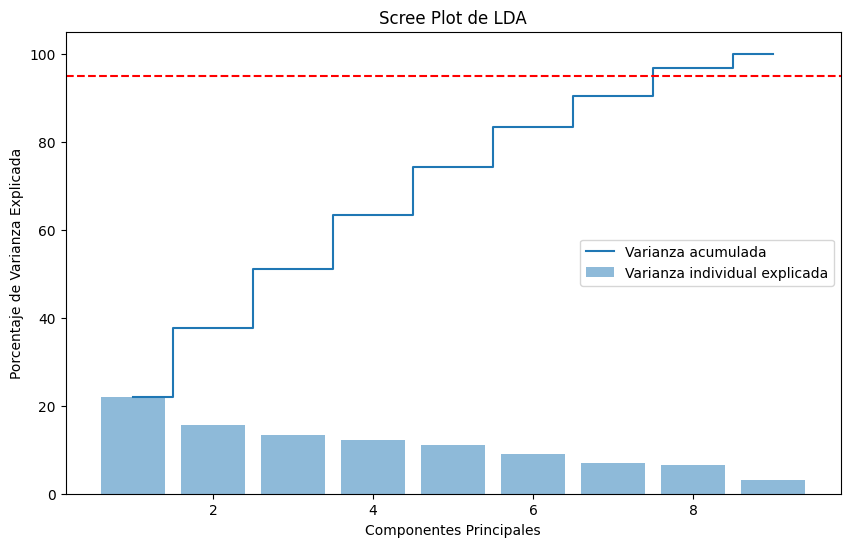

In [1683]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, Y_train.to_numpy())
X_train_lda = pd.DataFrame(lda.transform(X_train.to_numpy()))
print(X_train_lda.shape)
varianza_explicada = lda.explained_variance_ratio_ * 100
num_componentes = np.arange(len(varianza_explicada)) + 1

graph_components(num_componentes, "LDA", varianza_explicada)

A diferencia de PCA y SVD, LDA es un algoritmo de reducción de dimensionalidad supervisado, le paso los labels. El número de componentes está limitado por *min(n_classes - 1, n_features)*

In [1684]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, Y_train.to_numpy())

# Transformar los datos al nuevo espacio
features_transformed = lda.transform(X_train_scaled)      # features_transformed es un numpy array
X_train_lda = pd.DataFrame(features_transformed)   # features_imputed es un DataFrame de pandas

# Test
features_transformed = lda.transform(X_test_scaled)      # features_transformed es un numpy array
X_test_lda = pd.DataFrame(features_transformed)   # features_imputed es un DataFrame de pandas

# Validation
features_transformed = lda.transform(X_val_scaled)      # features_transformed es un numpy array
X_val_lda = pd.DataFrame(features_transformed)   # features_imputed es un DataFrame de pandas

#### UMAP

In [1685]:
# !pip install umap-learn
# !pip install umap-learn[plot]
# !pip install dask[dataframe]

In [1686]:
import umap
from sklearn.preprocessing import LabelEncoder

reducer = umap.UMAP()

X_train_reduced = reducer.fit(X_train_scaled)

X_train_umap = pd.DataFrame(reducer.transform(X_train_scaled))
X_val_umap = pd.DataFrame(reducer.transform(X_val_scaled))
X_test_umap = pd.DataFrame(reducer.transform(X_test_scaled))

label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_val_encoded = label_encoder.fit_transform(Y_val)
# Calculates number of clusters so that it's equal to the number of labels 
n_clusters = len(np.unique(Y_train_encoded))
print(n_clusters)

10


In [1687]:
print(type(reducer))
print(type(reducer.transform(X_train_scaled)))

<class 'umap.umap_.UMAP'>
<class 'numpy.ndarray'>


<Axes: >

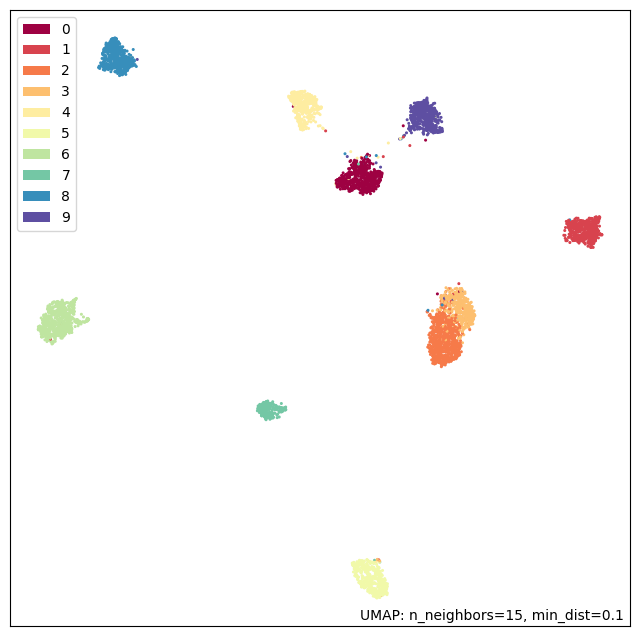

In [1688]:
import umap.plot

umap.plot.points(X_train_reduced, labels=Y_train_encoded)

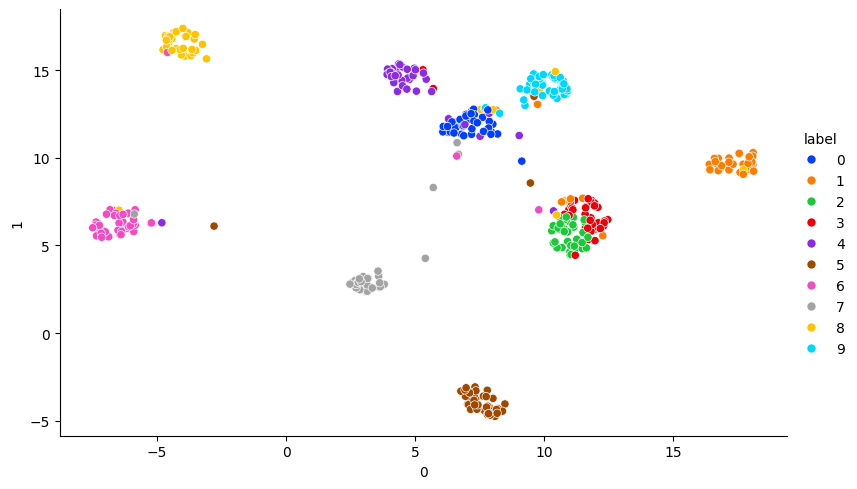

In [1689]:
df_val_draw = X_val_umap.copy()
df_val_draw["label"] = Y_val_encoded

sns.relplot(data=df_val_draw, x=0, y=1, hue='label', aspect=1.61, palette="bright")

plt.show()

In [1690]:
print(X_train_umap.shape)
print(X_val_umap.shape)
print(X_test_umap.shape)

(5424, 2)
(422, 2)
(805, 2)


### Accuracy testing

#### Kmeans

In [1691]:
from sklearn.preprocessing import LabelEncoder
from kmeans import kmeans

label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
# Calculates number of clusters so that it's equal to the number of labels 
n_clusters = len(np.unique(Y_train_encoded))
print(n_clusters)

10


In [1692]:
X_train_lda_np = X_train_lda.to_numpy()
umbral = 0.1
centroides_km_lda, clusters_km_lda = kmeans(X_train_lda_np, n_clusters, umbral)

In [1693]:
X_train_umap_np = X_train_umap.to_numpy()
centroides_km_umap, clusters_km_umap = kmeans(X_train_umap_np, n_clusters, umbral)

#### DBSCAN

In [1694]:
from dbscan import DBSCAN
radio = 0.5
vecinos_min = 10

labels_db_lda = DBSCAN(X_train_lda_np, radio, vecinos_min)
labels_db_umap = DBSCAN(X_train_umap_np, radio, vecinos_min)

#### Resultados

In [1695]:
from sklearn.metrics.cluster import rand_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import mutual_info_score

In [1696]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets
X, y = datasets.load_iris(return_X_y=True)
print(X.shape)

(150, 4)


In [1697]:
ri_lda_km = rand_score(Y_train_encoded, clusters_km_lda)
ri_umap_km = rand_score(Y_train_encoded, clusters_km_umap)
print("El rand index de kmeans con lda es: ", ri_lda_km)
print("El rand index de kmeans con umap es: ", ri_umap_km)

sc_lda_km = silhouette_score(X_train_lda_np, clusters_km_lda)
sc_umap_km = silhouette_score(X_train_umap_np, clusters_km_umap)
print("El silhouette coefficient de kmeans con lda es: ", sc_lda_km)
print("El silhouette coefficient de kmeans con umap es: ", sc_umap_km)

mi_lda_km = mutual_info_score(Y_train_encoded, clusters_km_lda)
mi_umap_km = mutual_info_score(Y_train_encoded, clusters_km_umap)
print("El mutual information de kmeans con lda es: ", mi_lda_km)
print("El mutual information de kmeans con umap es: ", mi_umap_km)

El rand index de kmeans con lda es:  0.860975077744361
El rand index de kmeans con umap es:  0.9278074186369973
El silhouette coefficient de kmeans con lda es:  0.017428732716435497
El silhouette coefficient de kmeans con umap es:  0.5300145
El mutual information de kmeans con lda es:  1.0725910903893323
El mutual information de kmeans con umap es:  1.8243288432758367


<Axes: >

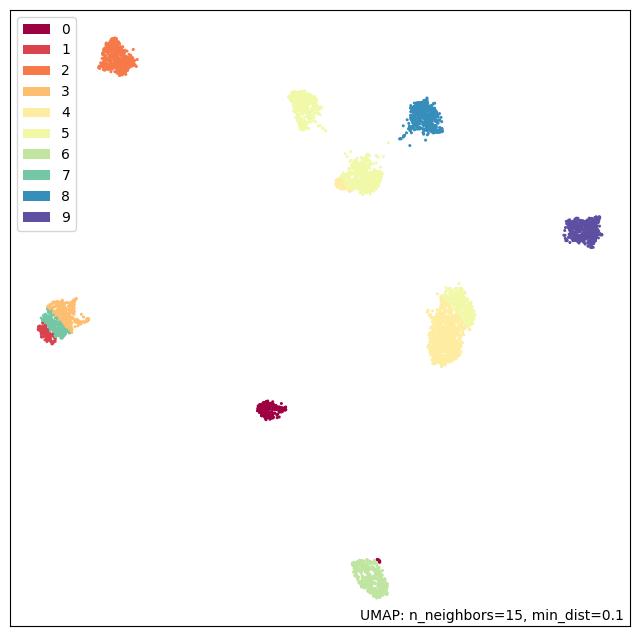

In [1698]:
umap.plot.points(X_train_reduced, labels=clusters_km_umap)

In [1703]:
print(labels_db_umap)

[1, 2, 2, 3, 4, 5, 4, 5, 2, 6, 7, 1, 8, 4, 3, 1, 3, 1, 1, 3, 4, 6, 2, 7, 3, 6, 6, 4, 4, 1, 8, 9, 7, 2, 4, 2, 2, 2, 3, 4, 7, 9, 1, 4, 7, 3, 5, 4, 2, 2, 3, 2, 7, 8, 5, 9, 4, 5, 2, 6, 2, 2, 3, 3, 4, 2, 9, 8, 3, 2, 6, 9, 9, 1, 2, 2, 4, 5, 8, 2, 1, 3, 7, 6, 9, 2, 4, 1, 2, 9, 2, 1, 7, 3, 3, 2, 1, 2, 6, 4, 3, 2, 5, 7, 1, 1, 9, 7, 2, 4, 5, 3, 7, 2, 6, 4, 2, 2, 4, 1, 4, 8, 4, 2, 3, 1, 1, 1, 7, 6, 7, 9, 9, 3, 1, 7, 2, 3, 3, 1, 4, 2, 9, 4, 2, 7, 8, 8, 2, 6, 7, 9, 4, 7, 1, 7, 5, 7, 7, 2, 4, 4, 8, 9, 2, 2, 4, 4, 5, 6, 7, 5, 2, 7, 6, 3, 4, 1, 4, 8, 3, 6, 3, 1, 9, 1, 9, 7, 6, 3, 5, 2, 4, 1, 4, 5, 5, 7, 6, 9, 7, 1, 1, 7, 2, 1, 2, 1, 9, 7, 2, 2, 1, 2, 9, 8, 1, 4, 4, 7, 4, 9, 2, 2, 6, 9, 6, 2, 1, 7, 4, 6, 3, 2, 9, 9, 8, 5, 9, 9, 6, 7, 8, 3, 7, 9, 1, 7, 6, 7, 2, 7, 5, 6, 9, 2, 9, 9, 7, 7, 2, 1, 6, 6, 5, 7, 8, 1, 1, 9, 5, 1, 7, 8, 1, 1, 7, 2, 2, 2, 6, 6, 2, 9, 2, 6, 7, 6, 1, 2, 2, 5, 5, 9, 7, 2, 5, 2, 2, 1, 4, 2, 1, 4, 6, 9, 9, 3, 8, 4, 7, 3, 7, 2, 7, 1, 6, 1, 9, 8, 2, 8, 7, 4, 4, 4, 1, 9, 4, 5, 2, 5, 4, 

In [1699]:
labels_db_lda_np = np.array(labels_db_lda)
labels_db_umap_np = np.array(labels_db_umap)

ri_lda_db = rand_score(Y_train_encoded, labels_db_lda_np)
ri_umap_db = rand_score(Y_train_encoded, labels_db_umap_np)
print("El rand index de DBSCAN con lda es: ", ri_lda_db)
print("El rand index de DBSCAN con umap es: ", ri_umap_db)

Y_train_encoded_np = Y_train_encoded.reshape(-1, 1)

sc_lda_db = silhouette_score(X_train_lda_np, labels_db_lda_np)
sc_umap_db = silhouette_score(X_train_umap_np, labels_db_umap_np)
print("El silhouette coefficient de DBSCAN con lda es: ", sc_lda_db)
print("El silhouette coefficient de DBSCAN con umap es: ", sc_umap_db)

mi_lda_db = mutual_info_score(Y_train_encoded, labels_db_lda_np)
mi_umap_db = mutual_info_score(Y_train_encoded, labels_db_umap_np)

print("El mutual information de DBSCAN con lca es: ", mi_lda_db)
print("El mutual information de DBSCAN con umap es: ", mi_umap_db)

El rand index de DBSCAN con lda es:  0.10584948463253585
El rand index de DBSCAN con umap es:  0.9726744277759374


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [ ]:
umap.plot.points(X_train_reduced, labels=labels_db_umap_np)

### Validation

In [ ]:
label_encoder = LabelEncoder()
Y_val_encoded = label_encoder.fit_transform(Y_val)

X_val_lda_np = X_val_lda.to_numpy()
X_val_umap_np = X_val_umap.to_numpy()

umbral = 0.06
centroides_km_lda, clusters_km_lda = kmeans(X_val_lda_np, n_clusters, umbral)
centroides_km_umap, clusters_km_umap = kmeans(X_val_umap_np, n_clusters, umbral)

In [ ]:
ri_lda_km = rand_score(Y_val_encoded, clusters_km_lda)
ri_umap_km = rand_score(Y_val_encoded, clusters_km_umap)
print("El rand index de kmeans con lda es: ", ri_lda_km)
print("El rand index de kmeans con umap es: ", ri_umap_km)

sc_lda_km = silhouette_score(X_val_lda_np, clusters_km_lda)
sc_umap_km = silhouette_score(X_val_umap_np, clusters_km_umap)
print("El silhouette coefficient de kmeans con lda es: ", sc_lda_km)
print("El silhouette coefficient de kmeans con umap es: ", sc_umap_km)

mi_lda_km = mutual_info_score(Y_val_encoded, clusters_km_lda)
mi_umap_km = mutual_info_score(Y_val_encoded, clusters_km_umap)
print("El mutual information de kmeans con lda es: ", mi_lda_km)
print("El mutual information de kmeans con umap es: ", mi_umap_km)

In [ ]:
df_val_draw = X_val_umap.copy()
df_val_draw["label"] = clusters_km_umap

sns.relplot(data=df_val_draw, x=0, y=1, hue='label', aspect=1.61, palette="bright")

plt.show()

In [ ]:
# At arround 0.5 and below, the clusters are normally more than 10. The outliers also increase
# At arround 1.5 and below, the clusters are normally less than 10. The outliers also decrease
# See the kaggle submissions to see how the radio influences
radio = 0.74
vecinos_min = 10

labels_db_lda = DBSCAN(X_val_lda_np, radio, vecinos_min)
labels_db_umap = DBSCAN(X_val_umap_np, radio, vecinos_min)

In [ ]:
labels_db_lda_np = np.array(labels_db_lda)
labels_db_umap_np = np.array(labels_db_umap)

ri_lda_db = rand_score(Y_val_encoded, labels_db_lda_np)
ri_umap_db = rand_score(Y_val_encoded, labels_db_umap_np)
print("El rand index de DBSCAN con lda es: ", ri_lda_db)
print("El rand index de DBSCAN con umap es: ", ri_umap_db)

Y_train_encoded_np = Y_train_encoded.reshape(-1, 1)

sc_lda_db = silhouette_score(X_val_lda_np, labels_db_lda_np)
sc_umap_db = silhouette_score(X_val_umap_np, labels_db_umap_np)
print("El silhouette coefficient de DBSCAN con lda es: ", sc_lda_db)
print("El silhouette coefficient de DBSCAN con umap es: ", sc_umap_db)

mi_lda_db = mutual_info_score(Y_val_encoded, labels_db_lda_np)
mi_umap_db = mutual_info_score(Y_val_encoded, labels_db_umap_np)

print("El mutual information de DBSCAN con lca es: ", mi_lda_db)
print("El mutual information de DBSCAN con umap es: ", mi_umap_db)

In [ ]:
df_val_draw = X_val_umap.copy()
df_val_draw["label"] = labels_db_umap_np

sns.relplot(data=df_val_draw, x=0, y=1, hue='label', aspect=1.61, palette="bright")

plt.show()

### Testing

In [ ]:
X_test_lda_np = X_test_lda.to_numpy()
X_test_umap_np = X_test_umap.to_numpy()

centroides_km_lda, clusters_km_lda = kmeans(X_test_lda_np, n_clusters, umbral)

centroides_km_umap, clusters_km_umap = kmeans(X_test_umap_np, n_clusters, umbral)

labels_db_lda = DBSCAN(X_test_lda_np, radio, vecinos_min)

labels_db_umap = DBSCAN(X_test_umap_np, radio, vecinos_min)

In [ ]:
df_test_draw = X_test_umap.copy()
df_test_draw["label"] = clusters_km_umap

sns.relplot(data=df_test_draw, x=0, y=1, hue='label', aspect=1.61, palette="bright")

plt.show()

In [ ]:
df_test_draw = X_test_umap.copy()
df_test_draw["label"] = labels_db_umap
print(df_test_draw)

sns.relplot(data=df_test_draw, x=0, y=1, hue='label', aspect=1.61, palette="bright")

plt.show()

In [ ]:
print(type(clusters_km_umap))
df = pd.read_csv('./datasets/test_r21d_complete_10.csv')       # data training con el target
Y_test = df.iloc[:,-1:].copy()
print(Y_test)

In [ ]:
# guardar en csv el test

Y_test.loc[:, "label"] = clusters_km_lda
Y_test = Y_test.set_index("youtube_id")

Y_test.to_csv("results/y_test_km_lda_" + str(umbral) + ".csv")

Y_test.loc[:, "label"] = clusters_km_umap

Y_test.to_csv("results/y_test_km_umap_" + str(umbral) + ".csv")

Y_test.loc[:, "label"] = labels_db_lda

Y_test.to_csv("results/y_test_dbscan_lda_" + str(radio) + "_" + str(vecinos_min) + ".csv")

Y_test.loc[:, "label"] = labels_db_umap

Y_test.to_csv("results/y_test_dbscan_umap_" + str(radio) +"_" + str(vecinos_min) + ".csv")